## Notebook to apply sst binning to data from raman lidar
#### Author: Claudia Acquistapace
#### Date: 08/12/2021
#### Goal: reading data without diurnal cycle, filter out rainy time stamps and calculate mean profiles for each sst bin. The script then saves the variables binned on sst in a ncdf file. 

In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
#from myFunctions import lcl
#from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker


def f_interpolate_SST_and_merge(SST_DS, dataset_obs):
    '''function to interpolate SST values on the time resolution of the observations given as input
    input: 
    SST_DS: xarray dataset containing sst values
    dataset_obs: xarray dataset containing the observations to merge with sst data
    output: 
    data_merged: data returned 
    '''
    
    # interpolating sst data at 1 min resolution to the 10 s res of the wind lidar
    sst_data_interp = SST_DS.interp(time=dataset_obs['time'].values)

    # merging the interpolated dataset and the wind lidar dataset
    data_merged = xr.merge([dataset_obs, sst_data_interp])
    return(data_merged)


def f_calculate_binned_data(data_input, SST_binned_arr):
    
    ''' function to calculate mean values of all variables for each SST bin, for all instruments
    author: Claudia Acquistapace
    date: 20 Sept 2021
    input: - data_input: input xarray dataset containing the variables as a function of time, height, to be averaged
            - SST_binned_arr: numpy array of sst binned values for calculating the mean 
    output: dataset_concat: xarray dataset of concatenated values with mean profiles corresponding to the sst bins. A variable n_el counts the number of profiles averaged together
    '''
    # calculating mean quantities f
    dataset_mean = []

    data_input = data_input.load()

    # selecting all columns in the bin interval
    for ind_bin in range(len(SST_binned_arr)-1):

        # selecting slices of datasets columns with SST values in the selected bin
        DS_sliced = data_merged.where((data_input.SST > SST_binned_arr[ind_bin]) & (data_input.SST < SST_binned_arr[ind_bin+1]), drop=True)

        # add variable of the number of elements of the slice
        n_el = len(DS_sliced.SST.values)
        DS_sliced['n_elements'] = n_el

        # calculate mean profile averaging all selected time stamps together
        dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))


    # concatenating datasets corresponding to SST bins on a new bin dimension
    dataset_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
    return(dataset_concat)




dict_plot_settings = {
    'labelsizeaxes':14,
    'fontSizeTitle':16,
    'fontSizeX'    :16,
    'fontSizeY'    :16,
    'cbarAspect'   :10,
    'fontSizeCbar' :16,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :22, 
    'grid'         :True}




data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/'
tsg_file = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc"
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'


reading data from tsg and create SST dataset

In [2]:
# reading data containing flags to filter out rainy columns
flag_file_list = np.sort(glob.glob('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/*_flags_cloud_properties.nc'))
flag_file_list = flag_file_list[13:15]

flag_data = xr.open_mfdataset(flag_file_list)

In [3]:
# reading tsg file ( data with 1 min resolution)
tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords         = {"time":sliced_tsg_ds.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
SST_DS      = xr.Dataset(data_vars = variables,
                       coords = coords)


definition of the functions for: 
- Interpolation of the SST on the time grid of each instrument
- binning of the data over SST grid


In [4]:
# building SST binned array
SST_min = np.nanmin(sst_tsg)
SST_max = np.nanmax(sst_tsg)
SST_binned_arr = np.arange(SST_min, SST_max, step=0.025)


# calculate label marks for bins
sst_bin_label = []
for ind in range(len(SST_binned_arr)-1):
    sst_bin_label.append(round((SST_binned_arr[ind]+SST_binned_arr[ind+1])/2,2))
    


In [5]:
a = np.ones((4,3))
a[2,0]= np.nan
print(a)
print(np.count_nonzero(~np.isnan(a), axis=0))



[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [nan  1.  1.]
 [ 1.  1.  1.]]
[3 4 4]


Reading data from Arthus for T, wvmr, SHF, LHF.

In [19]:
# reading all arthus data 

# variable list
var_list =['T','WVMR','VW','LHF','SHF']

T_dict = {
     'var_name'  : 'T',
     'var_string': 'Temperature',
     'var_units' : ' $^{\circ}$K',
     'var_min'   : 290.,
     'var_max'   : 310.,
     'thr_min'   : 280.,
     'thr_max'   : 330.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Air temperature: 28/01-04/02'}

WVMR_dict = {
     'var_name'  : 'MR',
     'var_string': 'Water vapor mixing ratio',
     'var_units' : ' g kg$^{-1}$',
     'var_min'   : 0.,
     'var_max'   : 30.,
     'thr_min'   : 0.,
     'thr_max'   : 30.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Water vapor mixing ratio: 28/01-04/02'}

VW_dict = {
     'var_name'  : 'VW',
     'var_string': 'Vertical velocity',
     'var_units' : ' ms$^{-1}$',
     'var_min'   : -2.,
     'var_max'   : 2.,
     'thr_min'   : -5.,
     'thr_max'   : 5.,
     'avg_time'  : '15',
     'cmap'      : 'seismic',
     'title'     : 'Vertical velocity: 28/01-04/02'}

LHF_dict = {
     'var_name'  : 'LHF',    
     'var_string': 'Latent heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -250.,
     'var_max'   : 250.,
     'thr_min'   : -250.,
     'thr_max'   : 250.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Latent heat flux: 28/01-04/02'}

SHF_dict = {
     'var_name'  : 'SHF',
     'var_string': 'Sensible heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -100.,
     'var_max'   : 100.,
     'thr_min'   : -100.,
     'thr_max'   : 100.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Sensible heat flux: 28/01-04/02'}


dict_list = [T_dict, WVMR_dict, VW_dict, LHF_dict, SHF_dict]



vars_arthus = []

for i_var, dict_var in enumerate(dict_list):

    print('processing variable: ', dict_var['var_string'])
    
    # reading file list of the files for the selected variable
    arthus_file_list = np.sort(glob.glob(data_path+dict_var['var_name']+'*.nc'))

    # read the two datasets together
    arthus_dataset = xr.open_mfdataset(arthus_file_list)
    
    # renaming variable time and height and dimension time and height (step necessary for next operations)
    #arthus_dataset = arthus_dataset.rename_dims({'Time':'time'})
    #arthus_dataset = arthus_dataset.rename_dims({'Height':'height'})
    #arthus_dataset = arthus_dataset.rename_vars({'Time':'time'})
    #arthus_dataset = arthus_dataset.rename_vars({'Height':'height'})

    print('files read')

    # interpolate flag on time resolution of arthus data, picking the closest time stamp to lidar time stamps
    flag_data_interp = flag_data.interp(time=arthus_dataset['time'].values, method='nearest')

    print('flag interpolated')
    
    # building a mask to filter out Ze rainy columns and substitute them with nans
    # set to nan the values out of the thresholds for the selected variable
    mask = np.zeros((len(arthus_dataset.time.values), len(arthus_dataset.height.values)))
    for ind in range(len(flag_data_interp.time.values)):
        if (flag_data_interp["flag_rain_ground"].values[ind] == 1) | (flag_data_interp["flag_rain"].values[ind] == 1):
            mask[ind,:] = np.repeat(1, len(arthus_dataset.height.values))

    print('mask calculated')
    
    arthus_dataset["nans"] = xr.full_like(arthus_dataset.product_no_diurnal_cycle, fill_value=np.nan)
    arthus_dataset['product_no_diurnal_cycle'] = xr.where(mask == 0, arthus_dataset['product_no_diurnal_cycle'], arthus_dataset["nans"])

    
    # interpolating SST data on the arthus data 
    arthus_all_SST = f_interpolate_SST_and_merge(SST_DS, arthus_dataset)


    # calculating mean quantities for each bin
    dataset_mean = []
    dataset_std = []
    dataset_n = []
    
    # selecting all columns in the bin interval
    for ind_bin in range(len(SST_binned_arr)-1):

        # selecting slices of datasets columns with SST values in the selected bin
        DS_sliced = arthus_all_SST.where((arthus_all_SST.SST > SST_binned_arr[ind_bin]) & (arthus_all_SST.SST < SST_binned_arr[ind_bin+1]), drop=True)

        # add variable of the number of elements of the slice
        n_el = len(DS_sliced.SST.values)
        
        # add variable of absolute value of the var
        dims_ds = ['time','height']
        coords_ds = {'time':DS_sliced['time'].values, 'height':DS_sliced['height'].values}
        abs_val = np.abs(DS_sliced['product_no_diurnal_cycle'].values)
        DS_sliced['abs_val'] =  xr.DataArray(dims=dims_ds, coords=coords_ds, data=abs_val)

    
        # add variable of count of values for each sliced dataset where we calculate mean/std 
        dims_ds = ['time','height']
        coords_ds = {'time':DS_sliced['time'].values, 'height':DS_sliced['height'].values}
        counts = np.count_nonzero(~np.isnan(DS_sliced['product_no_diurnal_cycle'].values), axis=0)
        print(np.shape(counts))
        print(counts)
        DS_sliced['n_elements'] =  xr.DataArray(dims=['height'], \
                                                coords={'height':DS_sliced['height'].values}, \
                                                data=counts, 
                                               attrs={'long_name':'number of values in each bin SST/height'})        
        
        
        # calculate mean profile averaging all selected time stamps together
        dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))
        dataset_std.append(DS_sliced.std(dim='time', skipna=True))
        dataset_n.append(DS_sliced['n_elements'])
        
        
    # concatenating datasets corresponding to SST bins on a new bin dimension
    arthus_SST_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
    arthus_SST_std_concat = xr.concat([dataset_std[i] for i in np.arange(len(dataset_std))], dim='SST_binned')
    arthus_SST_n_concat = xr.concat([dataset_n[i] for i in np.arange(len(dataset_n))], dim='SST_binned')
    
    
    # saving variable of interest in a dictionary with its name: for vertical velocity (VW) we save the absolute value
    # of vertical velocity for mean variable, and the std of the vertical velocity values.
    if dict_var['var_name']!= 'VW':
        dict_variable_nodc = {'var_name':dict_var['var_name'],
                     'var':arthus_SST_concat['product_no_diurnal_cycle'].values, 
                     'std':arthus_SST_std_concat['product_no_diurnal_cycle'].values,
                      'n':arthus_SST_n_concat.data}
    else:
        dict_variable_nodc = {'var_name':dict_var['var_name'],
                     'var':arthus_SST_concat['abs_val'].values, 
                     'std':arthus_SST_std_concat['product_no_diurnal_cycle'].values,
                      'n':arthus_SST_n_concat.data}       
    
    
    # append the dictionary in a list of dictionaries containing all arthus variables
    vars_arthus.append(dict_variable_nodc)


processing variable:  Temperature
files read
flag interpolated
mask calculated
(57,)
[188 188 188 188 188 188 186 185 184 183 183 178 171 159 153 137 133 133
 121 114 105 105  98  95  95  94  89  88  77  73  71  72  61  60  55  62
  59  49  52  48  36  32  26  22  36  18  15  11   8   6   7   4   0   1
   0   0   0]
(57,)
[105 105 105 105 105 105 105 104 102 102 102 102 102 102 100 101  99  99
  99  99  99  97  95  91  92  91  81  74  70  72  66  65  61  49  53  47
  42  38  42  35  34  32  30  23  25  16  15  11   2   4   7   6   3   0
   0   0   0]
(57,)
[155 155 155 155 155 155 155 155 155 153 153 153 152 149 144 142 142 142
 142 142 143 142 142 139 135 138 116 101 100 109 102  89  82  77  76  68
  69  62  57  44  57  44  36  44  29  25  29  10  12  10   7   5   3   1
   0   0   0]
(57,)
[183 183 183 183 183 183 183 183 183 183 183 183 183 183 177 161 153 138
 117 114 100  90  88  87  81  83  73  69  71  60  55  44  44  43  40  36
  32  33  31  33  25  17  30  21  23  17  23  15  11

(57,)
[302 302 281 271 258 255 248 234 229 226 225 224 224 219 219 214 206 198
 196 193 193 192 189 188 186 190 184 187 182 169 166 160 157 160 153 146
 140 135 135 124 118 110  96  98  84  79  74  67  64  55  45  41  21  15
   7   0   0]
(57,)
[333 332 330 311 298 284 275 269 260 257 257 256 255 253 252 250 233 224
 208 199 192 190 187 187 187 185 185 184 183 179 175 172 172 170 162 154
 151 144 147 138 131 127 111 110 100  89  80  77  69  67  46  33  24  10
   5   0   0]
(57,)
[225 225 218 210 185 176 163 150 147 142 135 135 134 133 131 127 122 118
 112 106 103 101  99  97  97  95  89  86  90  82  84  81  77  77  75  71
  70  66  63  62  58  58  58  53  47  45  39  36  33  34  32  26  18  10
   3   0   0]
(57,)
[157 157 157 157 154 153 153 152 152 151 150 147 147 147 144 143 141 139
 134 131 126 122 124 123 117 122 117 119 114 105 111 109 106 102  93  84
  93  92  87  68  69  56  48  38  42  37  34  38  29  18  17  11   9   4
   1   0   0]
(57,)
[170 170 170 169 165 154 151 145 140 1

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


processing variable:  Water vapor mixing ratio
files read
flag interpolated
mask calculated
(57,)
[188 188 188 188 188 188 186 185 184 183 183 171 162 143 141 129 125 117
 102  98  89  72  72  66  68  70  63  47  45  36  23  31  23  24  24  20
  15  13   9  12   7   9   4   3   2   2   3   1   1   3   2   1   0   0
   0   0   0]
(57,)
[105 105 105 105 105 105 105 104 102 102 102 102 102 100 100 100  99  99
  95  97  91  89  78  76  66  65  53  42  45  47  34  31  22  20  15  19
  22   8  19  15  17   8   6   3   2  10   3   1   2   0   0   3   1   0
   0   0   0]
(57,)
[155 155 155 155 155 155 155 155 155 153 153 153 152 149 141 142 141 137
 135 137 127 125 122 115 103  85  73  69  68  43  51  56  40  37  36  31
  13  18  16  16   9   8  11   6   7   4   5   1   3   3   3   1   0   0
   1   0   0]
(57,)
[183 183 183 183 183 183 183 183 183 183 183 183 183 183 173 160 151 132
 110 106  91  83  82  74  58  54  38  43  34  30  25  21  12  19  19  16
  10  12   6   9   8   1   5   1  11   

(57,)
[200 200 200 200 200 193 189 184 178 177 177 174 173 172 172 172 167 160
 156 155 152 146 141 138 129 122 112  96 107  91  81  88  70  61  49  57
  56  42  44  31  40  33  36  30  25  14  15  17  16   9  12   8   4   5
   1   0   0]
(57,)
[175 175 174 173 172 171 167 166 163 160 156 155 154 154 152 150 149 148
 148 143 137 129 116 111 107 109  97  89  84  79  71  67  57  48  37  40
  48  45  44  30  33  30  21  24  20  21  18  13  17   9   6   6   3   2
   1   0   0]
(57,)
[267 265 254 249 239 235 229 229 229 227 226 224 223 223 223 222 208 199
 192 183 172 150 143 136 126 128 124 118 118 104  96  89  77  67  67  58
  55  51  47  48  44  35  35  32  42  21  18  20  17  16  10  10  10   5
   2   0   0]
(57,)
[334 334 333 324 316 306 298 293 289 284 282 278 278 277 277 277 267 243
 221 202 182 166 157 151 139 132 122 111 102  95  89  68  57  43  51  51
  46  54  44  39  43  42  33  28  24  15  17  19  13  10   9   5   5   2
   0   0   0]
(57,)
[259 259 259 259 257 255 252 251 250 2

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


processing variable:  Vertical velocity
files read
flag interpolated
mask calculated
(57,)
[182 182 182 182 182 182 180 179 178 177 177 177 177 177 171 173 169 165
 166 159 147 160 159 139 160 156 149 154 147 139 150 150 139 139 144  99
 126 117  83 124 109  84  97  94  69  80  73  44  58  53  30  36  21  12
   2   0   0]
(57,)
[96 96 96 96 96 96 96 95 94 94 94 94 94 94 94 94 93 93 93 93 93 92 89 89
 89 88 86 85 85 85 85 80 79 78 70 58 67 58 41 54 50 41 42 43 35 34 28 18
 18 16 10  9  6  3  1  0  0]
(57,)
[136 136 136 136 136 136 136 136 136 136 136 136 135 135 135 135 135 135
 135 135 135 135 135 135 135 135 134 133 133 133 133 130 130 127 125 111
 102 112  72  94  98  68  81  80  46  60  48  36  45  27  18  19  12   2
   4   0   0]
(57,)
[133 133 133 133 133 133 133 133 133 133 133 133 133 133 133 131 125 112
  90  86  75  67  65  65  63  61  60  59  58  57  55  55  54  51  49  48
  46  42  32  40  36  24  34  31  23  29  27  21  26  21  11  16  11   5
   1   0   0]
(57,)
[87 87 87 8

(57,)
[200 200 200 200 200 193 189 184 178 177 177 174 173 172 172 172 167 161
 163 161 158 156 147 144 144 143 143 140 138 140 138 137 135 135 130 123
 128 127 115 119 119 109 103  90  80  80  68  44  63  53  32  45  31  16
   3   0   0]
(57,)
[170 170 169 168 167 166 162 161 158 155 151 150 149 149 147 145 144 143
 143 138 135 131 123 117 119 120 115 119 115 115 117 112 108 112 110 102
 108 102 104 101 101  91  92  88  66  74  75  52  56  50  36  40  19   9
   5   0   0]
(57,)
[266 264 253 248 238 234 228 228 228 226 225 223 222 222 222 221 217 212
 206 196 191 174 169 158 161 159 152 156 156 145 157 152 144 154 151 128
 150 144 124 136 132  99 118 102  79  89  82  51  73  54  44  51  38  12
   4   0   0]
(57,)
[324 324 323 314 306 296 288 283 279 274 272 268 268 267 267 267 266 264
 259 238 221 209 212 193 207 207 189 201 188 180 194 193 169 182 188 165
 180 188 156 180 173 140 151 146 101 126 118  54  88  70  53  55  33  16
   3   0   0]
(57,)
[259 259 259 259 257 255 252 251 250 2

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


processing variable:  Latent heat flux
files read
flag interpolated
mask calculated
(57,)
[188 188 188 188 188 188 186 185 160 183 183 183 183   0 159  57  14  54
  14 146  14   0   0  14  14  51  14   0   0   0   0   0 133   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
(57,)
[105 105 105 105 105 105 105 104  94 102  94 102 102  42  94  94  84  93
  84  93  84  17  38  80  80  46  77  20  37  37  37  34  79  33   0   0
   0   0   0   0   0   0   0   0   0   0   4   0   0   0   0   0   0   0
   0   0   0]
(57,)
[155 155 155 155 155 155 155 155 142 153 142 153 152 141 141 141 141 141
 141 141 141 108 141 141 141 146 140  92 139 139 139 135 134 131   0   0
   0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0
   0   0   0]
(57,)
[183 183 183 183 183 183 183 183 133 183 133 156 156 133 133 131 125 112
  90  86  75  67  65  65  63  79  60  33  58  57  55  55  48  51   0   0
   0   0   0   0   0   0   0   0   0   0   8   

(57,)
[334 294 260 324 316 306 298 245 289 284 282 278 207 277 277 252 242 274
 213 229 130  79 121  52  38 113 108  38  80  38  38  66  37  37  23   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
(57,)
[259 196 196 259 257 255 252 141 250 250 249 248 172 247 247 223 219 193
 162 220 105  85 133  80  10 137  44   9 118  10  46  36  10   9   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
(57,)
[347 333 333 343 341 337 335 320 331 329 329 329 328 328 328 312 301 264
 254 306 267 254 219 149  54 201  83  92  14 152  53   4   4   4   4   4
   3   2   2   2   2   2   1   1   1   1  18   1   1   1   1   1   1   1
   1   0   0]
(57,)
[119 119 119 117 115 115 113 113 113 113 113 113 113 113 112  55  69 109
  48  58  33  31  52  68  68   6  11   6   5  11  11   0   5   5   3   2
   0   2   0   2   0   0   2   2   0   1   0   0   0   0   0   0   0   0
   0   0   0]
(57,)
[88 88 86 82 81 76 75 74 73 72 71 71 7

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


processing variable:  Sensible heat flux
files read
flag interpolated
mask calculated
(57,)
[188 188 188 188 188 188 186 185 184  14 183 183 115  14  14  14  14  14
  14  14  14  14  14  14   0  14  14  14  14   0   0  14   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
(57,)
[105 105 105 105 105 105 105 104 102  85 102  94  94  85  85  85  84  84
  84  84  84  83  80  80  38  79  77  76  76  37  37  71  33  16   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
(57,)
[155 155 155 155 155 155 155 155 155 142 153 142 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 140 139 139 139 139 135 134  98   5   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
(57,)
[183 183 183 183 183 183 183 183 183 133 183 133 133 133 133 131 125 112
  90  86  75  67  65  65  63  61  60  59  58  57  55  55  54  45  24   0
   0   0   0   0   0   0   0   0   0   0   0 

(57,)
[175 175 174 173 172 171 167 166 163 160 156 155 154 154 135  93 136 136
 126 114 107 101  94  92  72  71  70  59  69  58  58  67  36  30  22   0
  22   0   0   6   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
(57,)
[267 265 254 249 239 235 229 229 229 227 226 224 223 223 175 131 213 175
 148 108 102  86  86  85  74  74  74  68  74  68  68  74  19  57   0   0
   0   0   0  14   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
(57,)
[334 334 333 324 316 306 298 293 289 284 282 278 278 260 211 130 194 185
 175  90  85  75  38  45  38  45  38  38  38  38  38  38   0  37   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
(57,)
[259 259 259 259 257 255 252 251 250 250 249 248 248 223 213 104 110 112
 162 146 142 122  10  61   9  42   9   9   9   9   9   9   0   9   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
(57,)
[347 347 347 343 341 337 335 334 331 3

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [17]:
arthus_SST_n_concat.data

array([[188, 188, 188, ...,   0,   0,   0],
       [105, 105, 105, ...,   0,   0,   0],
       [155, 155, 155, ...,   0,   0,   0],
       ...,
       [443, 443, 442, ...,   7,   0,   0],
       [281, 281, 281, ...,   4,   0,   0],
       [165, 165, 164, ...,   5,   0,   0]])

Saving all produced data in a ncdf file

In [20]:
# converting the list of dictionaries in a dictionary called variables to be saved in ncdf
dims             = ['sst','height']
coords           = {'sst':SST_binned_arr[0:-1], 'height':arthus_SST_concat['height'].values}
variables = {}
for i in range(len(dict_list)):
    key = vars_arthus[i]['var_name']
    value = xr.DataArray(dims=dims, coords=coords, data=vars_arthus[i]['var'],
                             attrs={'long_name':vars_arthus[i]['var_name']+' without diurnal cycle',
                                    'units':dict_var['var_units']})
    value_std = xr.DataArray(dims=dims, coords=coords, data=vars_arthus[i]['std'],
                             attrs={'long_name':'std of '+vars_arthus[i]['var_name']+' without diurnal cycle',
                                    'units':dict_var['var_units']})
    value_n = xr.DataArray(dims=dims, coords=coords, data=vars_arthus[i]['n'],
                             attrs={'long_name':'number of '+vars_arthus[i]['var_name']+' values in the bin',
                                    'units':'#'})
    variables[key] = value
    variables[key+'_std'] = value_std
    variables[key+'_n'] = value_n


global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                        'CREATED_ON'       :  str(datetime.now()),
                        'FILL_VALUE'       :  'NaN', 
                        'PI_NAME'          : 'Claudia Acquistapace',
                        'PI_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                        'PI_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                        'PI_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                        'DATA_DESCRIPTION' : dict_var['var_string']+'with the diurnal cycle removed from the data',
                        'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                        'DATA_GROUP'       : 'Experimental;Profile;Moving',
                        'DATA_SOURCE'      : 'arthus data',
                        'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                        'INSTRUMENT_MODEL' : 'arthus raman lidar system',
                         'COMMENT'         : 'original data postprocessed by Diego Lange' }
dataset_out    = xr.Dataset(data_vars = variables,
                        coords = coords,
                        attrs = global_attributes)
dataset_out.to_netcdf('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/arthus_binned_sst_3.nc')


NameError: name 'sst_bin_label_cf' is not defined

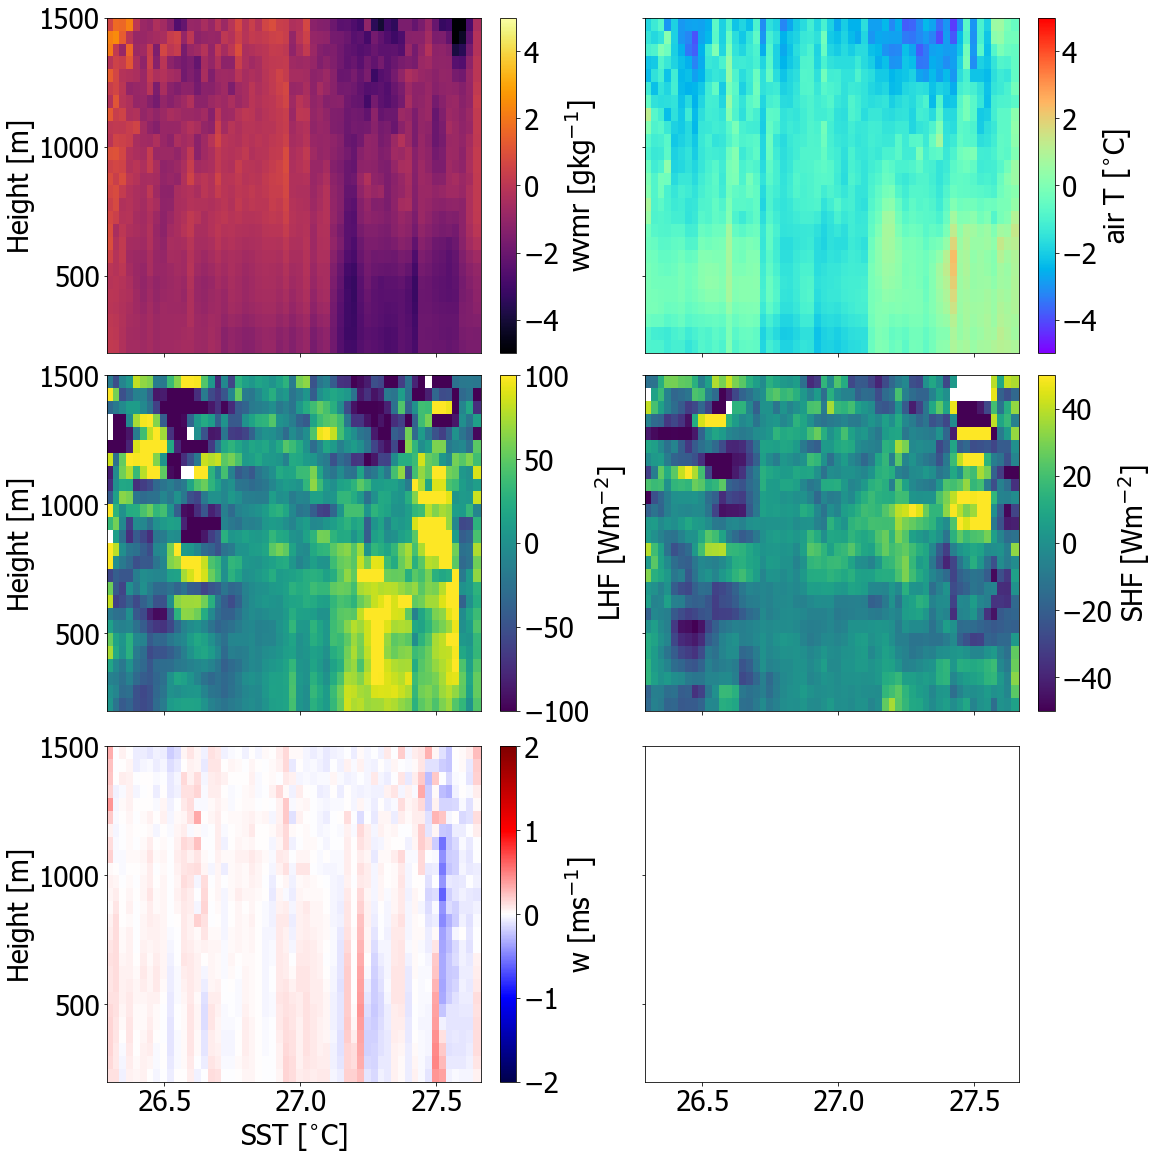

In [7]:
dict_plot_settings = {
    'labelsizeaxes':14,
    'fontSizeTitle':16,
    'fontSizeX'    :28,
    'fontSizeY'    :28,
    'cbarAspect'   :10,
    'fontSizeCbar' :28,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :28, 
    'grid'         :True}


# composite figure variables binned in sst 
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'

# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']

fig, axs = plt.subplots(3, 2, figsize=(16,16), sharey=True, sharex=True, constrained_layout=True)

green_diamond = dict(markerfacecolor='b', marker='D')

mesh = axs[0,0].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.MR.values.T, cmap='inferno', vmin=-5., vmax=5)
cbar = fig.colorbar(mesh, ax=axs[0,0])
cbar.set_label(label='wvmr [gkg$^{-1}$]',  size=fontSizeX)
axs[0,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[0,0].set_ylim(200,1500)

mesh = axs[0,1].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.T.values.T, cmap='rainbow', vmin=-5., vmax=5.)
cbar = fig.colorbar(mesh, ax=axs[0,1])
cbar.set_label(label='air T [$^{\circ}$C]',  size=fontSizeX)
axs[0,1].set_ylim(200,1500)

mesh = axs[1,0].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.LHF.values.T, cmap='viridis', vmin=-100., vmax=100.)
cbar = fig.colorbar(mesh, ax=axs[1,0])
cbar.set_label(label='LHF [Wm$^{-2}$]',  size=fontSizeX)
axs[1,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[1,0].set_ylim(200,1500)

mesh = axs[1,1].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.SHF.values.T, cmap='viridis', vmin=-50., vmax=50.)
cbar = fig.colorbar(mesh, ax=axs[1,1])
cbar.set_label(label='SHF [Wm$^{-2}$]', size=fontSizeX)
axs[1,1].set_ylim(200,1500)


mesh = axs[2,0].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.VW.values.T, cmap='seismic', vmin=-2., vmax=2.)
cbar = fig.colorbar(mesh, ax=axs[2,0])
cbar.set_label(label='w [ms$^{-1}$]',  size=fontSizeX)
axs[2,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[2,0].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)



mesh = axs[2,1].pcolormesh(sst_bin_label_cf, cloud_fraction_concat.height.values, cloud_fraction_concat.cloud_fraction.values.T, cmap='binary', vmin=0., vmax=0.5)
cbar = fig.colorbar(mesh, ax=axs[2,1])
cbar.set_label(label='cloud fraction []',  size=fontSizeX)
axs[2,1].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)


count = 0
for ax, l in zip(axs[:].flatten(), ['(a) ',  '(b) ',  '(c) ',  '(d) ', '(e) ', '(f) ']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.set_ylim(250.,1500.)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=26)
    #ax.grid(True, which='both', color='grey', linestyle=':')
    count = count+1
fig.savefig(path_out_plots+'profile_lidars_binned_sst.png')